In [3]:
!pip install pandas numpy matplotlib seaborn missingno orjson pyarrow

In [4]:
import matplotlib
import sys

def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

if not is_notebook():
    matplotlib.use('agg')  # Backend para scripts/terminal

import matplotlib.pyplot as plt

## 1. Carga de Datos

1.1 – Cargar playlists

In [5]:
import json, pandas as pd
from pathlib import Path

# root = Path(__file__).resolve().parents[1]   # carpeta proyecto
root = Path().resolve()
with open(root/'data/challenge_set.json', 'r', encoding='utf-8') as f:
    playlists_raw = json.load(f)

# Normalizar: una fila por playlist
playlists_df = pd.json_normalize(
    playlists_raw,
    meta=['pid', 'name', 'num_tracks', 'num_holdouts', 'num_samples']
)

# Convierte la lista 'tracks' en una sola columna de listas
print(playlists_df.columns.tolist())


['date', 'version', 'playlists', 'name', 'description']


1.2 – Eliminar playlists vacías


In [6]:
playlists = playlists_raw['playlists']  # Extraer la lista de playlists
playlists_df = pd.json_normalize(
    playlists,
    meta=['pid', 'name', 'num_tracks', 'num_holdouts', 'num_samples']
)
playlists_df = playlists_df[playlists_df['num_samples'] > 0].copy()
print(f"Playlists después del filtro: {len(playlists_df)}")

Playlists después del filtro: 9000


1.3 – Cargar features de AcousticBrainz

In [37]:
# 02_load_acoustic_flat_reduce.py
import orjson, pandas as pd
from pathlib import Path

# root = Path(__file__).resolve().parents[1]

# ---------- 1. Leer JSON ----------
with open(root / 'data/acousticbrainz_data_updated_clean.json', 'rb') as f:
    feat_dict = orjson.loads(f.read())          # {track_id: {...}}

# ---------- 2. Configuración ----------
# Categorías cuyo dict "all" queremos desplegar (mantendremos TODAS sus probabilidades)
CAT_WITH_ALL = {
    "genre_dortmund",
    "genre_electronic",
    "genre_rosamerica",
    "genre_tzanetakis",
    "ismir04_rhythm",
    
}

# Categorías de las que solo queremos *_value y *_prob (nada más)
CATS_KEEP_VAL_PROB = [
    "danceability", "gender",
    "mood_acoustic", "mood_aggressive", "mood_electronic",
    "mood_happy", "mood_party", "mood_relaxed", "mood_sad",
    "timbre", "tonal_atonal", "voice_instrumental",
    
]

# ---------- 3. Aplanar ----------
rows = []
for track_id, info in feat_dict.items():
    base = {k: v for k, v in info.items() if k != "highlevel"}  # bpm, energy…

    hl = info.get("highlevel", {})
    for cat, cat_dict in hl.items():
        # Siempre guarda value y prob (los filtraremos luego)
        base[f"{cat}_value"] = cat_dict.get("value")
        base[f"{cat}_prob"]  = cat_dict.get("probability")

        # Si está en la lista de "quiero todas las probs", añade dict all
        if cat in CAT_WITH_ALL:
            for subk, p in cat_dict.get("all", {}).items():
                base[f"{cat}_{subk}"] = p

    base["track_id"] = track_id
    rows.append(base)

tracks_feat_df = pd.DataFrame(rows)

# ---------- 4. Reducir columnas ----------
value_cols = [f"{c}_value" for c in CATS_KEEP_VAL_PROB]
prob_cols  = [f"{c}_prob"  for c in CATS_KEEP_VAL_PROB]

other_cols = [
    col for col in tracks_feat_df.columns
    if not (col.endswith("_value") or col.endswith("_prob"))
]

desired_cols = other_cols + value_cols + prob_cols
df_reduced = tracks_feat_df[desired_cols].copy()

# ---------- 5. Optimizar memoria ----------
float_cols = df_reduced.select_dtypes("float64").columns
df_reduced[float_cols] = df_reduced[float_cols].astype("float32")

print("Columnas originales:", len(tracks_feat_df.columns))
print("Columnas tras reducir:", len(df_reduced.columns))
print("Tamaño en memoria (MB):",
      df_reduced.memory_usage(deep=True).sum() / 1e6)

# ---------- 6. Guardar ----------
out = root / 'data' / 'processed'
out.mkdir(exist_ok=True, parents=True)

df_reduced.to_parquet(
    out / 'tracks_feat_flat.parquet',
    engine='pyarrow',
    compression='snappy',
    index=False
)
df_reduced.head()

Columnas originales: 115
Columnas tras reducir: 102
Tamaño en memoria (MB): 71.380704


,mbid,genre_mb,bpm,energy,danceability_ll,loudness,rating_votes,danceability_danceable,danceability_not_danceable,gender_female,gender_male,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_happy,mood_happy_not_happy,mood_party_not_party,mood_party_party,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_not_sad,mood_sad_sad,timbre_bright,timbre_dark,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_instrumental,voice_instrumental_voice,track_id,top_genre_hl,danceability_hl,mood_happy,acousticness,danceability_value,gender_value,mood_acoustic_value,mood_aggressive_value,mood_electronic_value,mood_happy_value,mood_party_value,mood_relaxed_value,mood_sad_value,timbre_value,tonal_atonal_value,voice_instrumental_value,danceability_prob,gender_prob,mood_acoustic_prob,mood_aggressive_prob,mood_electronic_prob,mood_happy_prob,mood_party_prob,mood_relaxed_prob,mood_sad_prob,timbre_prob,tonal_atonal_prob,voice_instrumental_prob
0,302944eb-7cb7-4045-b99c-c440c362718f,None,125.898476,4.910242,1.067135,0.816509,None,0.941562,0.058438,0.838504,0.161496,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,0.633230,0.022131,0.248523,0.030331,0.065786,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,0.072418,0.927582,3.396006e-01,0.660399,0.905014,0.094986,0.032647,0.967353,0.339192,0.660808,0.072720,0.927280,0.527017,0.472983,0.000930,0.999070,0.990423,0.009577,0.082268,0.917732,66U0ASk1VHZsqIkpMjKX3B,NaN,NaN,NaN,NaN,danceable,female,not_acoustic,not_aggressive,electronic,not_happy,party,relaxed,not_sad,dark,atonal,voice,0.941562,0.838504,0.927582,0.660399,0.905014,0.967353,0.660808,0.927280,0.527017,0.999070,0.990423,0.917732
1,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,None,128.037704,4.296187,0.937844,0.785428,None,0.492779,0.507221,0.409892,0.590108,0.001149,0.001203,0.991147,0.000679,0.000228,0.004117,0.000108,0.000572,0.000797,0.145308,0.018037,0.759690,0.035563,0.041402,0.014970,0.198387,0.431846,0.089087,0.050573,0.197856,0.010846,0.006436,0.039472,0.078931,0.063129,0.052604,0.045090,0.157818,0.063133,0.105224,0.078920,0.315679,0.069085,0.027921,0.003872,0.008992,0.006563,0.002090,0.018909,0.851566,0.008959,0.002044,0.000006,0.999994,3.000001e-14,1.000000,0.917834,0.082166,0.013071,0.986929,0.999164,0.000836,0.191173,0.808827,0.692220,0.307780,0.597991,0.402009,0.913942,0.086058,0.751203,0.248797,5MhsZlmKJG6X5kTHkdwC4B,NaN,NaN,NaN,NaN,not_danceable,male,not_acoustic,not_aggressive,electronic,not_happy,not_party,relaxed,not_sad,bright,atonal,instrumental,0.507221,0.590108,0.999994,1.000000,0.917834,0.986929,0.999164,0.808827,0.692220,0.597991,0.913942,0.751203
2,4b789101-f2f6-45f9-8a20-16705010a7a0,None,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,

1.4 – Expandir playlists a nivel canción

In [38]:

import pandas as pd, ast
from pathlib import Path

# root = Path(__file__).resolve().parents[1]
# playlists_df = pd.read_pickle(root/'data/playlists_df.pkl')

# ‘tracks’ es una lista de dicts → explode
playlists_df['tracks'] = playlists_df['tracks'].apply(lambda x: x)  # ya es lista
pl_tracks = playlists_df.explode('tracks', ignore_index=True)

# Cada dict track → columnas planas
tracks_cols = pd.json_normalize(pl_tracks['tracks'])
playlist_track_df = pd.concat(
    [pl_tracks[['pid','name']], tracks_cols], axis=1
)


1.5 – Unir features

In [39]:
# 1️⃣  Extrae el track-id puro de la URI dentro de las playlists
playlist_track_df['track_id'] = (
    playlist_track_df['track_uri']
      .str.split(':')
      .str[-1]             # último fragmento después del segundo ':'
)

# -------------------------------------------
# 2. Features-level  → asegúrate de tener track_id
#    (tras el script de aplanado, la columna YA se llama track_id)
# -------------------------------------------
# Si viniera como 'track_uri', la renombramos:
# tracks_feat_df.rename(columns={'track_uri': 'track_id'}, inplace=True)

# -------------------------------------------
# 3. Merge por track_id
# -------------------------------------------
playlist_track_full = playlist_track_df.merge(
    tracks_feat_df,
    on='track_id',
    how='left',
    validate='m:1'      # opcional: verifica que cada track_id exista máximo una vez en tracks_feat_df
)

# -------------------------------------------
# 4. Chequeo rápido
# -------------------------------------------
print(
    playlist_track_full[['track_uri', 'track_id', 'loudness']].head()
)
print("NaN en loudness:",
      playlist_track_full['loudness'].isna().mean()*100, "%")

                              track_uri                track_id  loudness
0  spotify:track:66U0ASk1VHZsqIkpMjKX3B  66U0ASk1VHZsqIkpMjKX3B  0.816509
1  spotify:track:5MhsZlmKJG6X5kTHkdwC4B  5MhsZlmKJG6X5kTHkdwC4B  0.785428
2  spotify:track:0GZoB8h0kqXn7XFm4Sj06k  0GZoB8h0kqXn7XFm4Sj06k       NaN
3  spotify:track:35kahykNu00FPysz3C2euR  35kahykNu00FPysz3C2euR       NaN
4  spotify:track:3G6hD9B2ZHOsgf4WfNu7X1  3G6hD9B2ZHOsgf4WfNu7X1  0.920415
NaN en loudness: 55.71103202846975 %


— Verificar % valor_faltante para features faltantes; tomar nota para imputación.

In [40]:
import pandas as pd
from pathlib import Path

# df = pd.read_parquet('data/processed/playlist_track_full.parquet')
df = playlist_track_full

# % de valores faltantes por columna
na_pct = df.isna().mean() * 100
na_pct = na_pct.sort_values(ascending=False)

pd.set_option('display.max_columns', None)      # Muestra todas las columnas
pd.set_option('display.width', None)            # Ajusta el ancho de impresión
pd.set_option('display.expand_frame_repr', False)  # No dividir filas en varias líneas


# Muestra las 20 peores columnas
# print(na_pct.head(20))
print(na_pct)

# (Opcional) Guarda el resumen
na_pct.to_csv('reports/missing_value_percentages.csv')

# Guarda el dataframe en parquet
playlist_track_full.to_parquet("data/processed/playlist_track_full.parquet")



genre_mb           100.0
rating_value       100.0
rating_votes       100.0
danceability_hl    100.0
top_genre_hl       100.0
                   ...  
duration_ms          0.0
track_name           0.0
artist_uri           0.0
album_name           0.0
track_id             0.0
Length: 125, dtype: float64


1.6 - Guardado de clean Dataframes

In [41]:
from pathlib import Path

# ------------------------------------------------------------------
# Asumimos que ya cargaste playlist_track_full (merge completo)
# ------------------------------------------------------------------
df = playlist_track_full.copy()

# =================================================================================
# PASO 1: IMPUTACIÓN CATEGÓRICA (LA CORRECCIÓN CLAVE)
# ¡Hacemos esto PRIMERO para arreglar los NaNs en las columnas *_value!
# =================================================================================
# Identificamos TODAS las columnas que son de tipo texto/objeto
all_categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Columnas categóricas a imputar: {len(all_categorical_cols)}")

# Creamos el imputer para rellenar los NaNs con un valor constante
# Usar 'desconocido' es una práctica estándar y robusta.
from sklearn.impute import SimpleImputer
imputer_cat_unified = SimpleImputer(strategy='constant', fill_value='desconocido')

# Aplicamos la imputación directamente al DataFrame
df[all_categorical_cols] = imputer_cat_unified.fit_transform(df[all_categorical_cols])

print("Imputación de columnas categóricas completada.\n")
# ---------------------------------------------------------------------------------


# ==============================================================
# PASO 2)  ELIMINAR COLUMNAS QUE SIGUEN SIENDO 100 % NaN
# (Esto podría eliminar columnas que ni siquiera la imputación pudo salvar)
# ==============================================================
na_pct = df.isna().mean()
cols_drop = na_pct[na_pct == 1.0].index
df_clean = df.drop(columns=cols_drop)

print(f"Columnas eliminadas por ser 100% NaN: {len(cols_drop)}")
# ---------------------------------------------------------------


# ==============================================================
# PASO 3)  IMPUTACIÓN NUMÉRICA (Tu lógica original, ahora en el orden correcto)
# ==============================================================
df_imputed = df_clean.copy()

# ---- 3.1  Identificamos las columnas numéricas relevantes ----
num_cols = df_imputed.select_dtypes(include=["number"]).columns

# ---- 3.2  Calculamos medias por playlist y rellenamos ----------
df_imputed[num_cols] = (
    df_imputed
      .groupby("pid")[num_cols]
      .transform(lambda col: col.fillna(col.mean()))
)

# ---- 3.3  Si aún quedan NaN, rellena con la mediana global -----
df_imputed[num_cols] = df_imputed[num_cols].fillna(df_imputed[num_cols].median())

# ---- 3.4  Bandera de imputación --------------------------------
# La calculamos comparando con el estado ANTES de la imputación numérica
was_na_numeric = df_clean[num_cols].isna().any(axis=1)
df_imputed["was_imputed"] = was_na_numeric.astype(int)

print("Filas imputadas con valores numéricos:", df_imputed['was_imputed'].sum())
# ---------------------------------------------------------------


# ==============================================================
# PASO 4)  (Opcional) DataFrame con registros COMPLETOS
#     (Este paso es opcional, ya que df_imputed es el principal)
# ==============================================================
# Ahora podemos crear el df_complete desde nuestro df_clean (que ya tiene las categóricas imputadas)
df_complete = df_clean.dropna(subset=num_cols).reset_index(drop=True)

print("Canciones con datos numéricos completos:", df_complete.shape)


# ==============================================================
# PASO 5)  (Opcional) Guardar resultados
# ==============================================================
out = Path("data/processed")
out.mkdir(parents=True, exist_ok=True)

df_complete.to_parquet(out / "playlist_tracks_complete.parquet", compression="snappy")
df_imputed.to_parquet(out / "playlist_tracks_imputed.parquet",  compression="snappy")

print("\n¡Proceso de limpieza e imputación finalizado y archivos guardados!")

Columnas categóricas a imputar: 30
Imputación de columnas categóricas completada.

Columnas eliminadas por ser 100% NaN: 7
Filas imputadas con valores numéricos: 156904
Canciones con datos numéricos completos: (124096, 118)

¡Proceso de limpieza e imputación finalizado y archivos guardados!


In [42]:
df_complete.head()

,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,danceability_danceable,danceability_not_danceable,gender_value,gender_prob,gender_female,gender_male,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_value,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_value,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_value,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_value,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_value,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_value,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_value,moods_mirex_prob,timbre_value,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_value,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_value,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,0.941562,0.058438,female,0.838504,0.838504,0.161496,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,0.072418,0.927582,not_aggressive,0.660399,3.396006e-01,0.660399,electronic,0.905014,0.905014,0.094986,not_happy,0.967353,0.032647,0.967353,party,0.660808,0.339192,0.660808,relaxed,0.927280,0.072720,0.927280,not_sad,0.527017,0.527017,0.472983,Cluster4,0.253382,dark,0.999070,0.000930,0.999070,atonal,0.990423,0.990423,0.009577,voice,0.917732,0.082268,0.917732
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,0.492779,0.507221,male,0.590108,0.409892,0.590108,electronic,0.991147,0.001149,0.001203,0.991147,0.000679,0.000228,0.004117,0.000108,0.000572,0.000797,house,0.759690,0.145308,0.018037,0.759690,0.035563,0.041402,hip,0.431

In [43]:
df_imputed.head()

,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,danceability_danceable,danceability_not_danceable,gender_value,gender_prob,gender_female,gender_male,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_acoustic_acoustic,mood_acoustic_not_acoustic,mood_aggressive_value,mood_aggressive_prob,mood_aggressive_aggressive,mood_aggressive_not_aggressive,mood_electronic_value,mood_electronic_prob,mood_electronic_electronic,mood_electronic_not_electronic,mood_happy_value,mood_happy_prob,mood_happy_happy,mood_happy_not_happy,mood_party_value,mood_party_prob,mood_party_not_party,mood_party_party,mood_relaxed_value,mood_relaxed_prob,mood_relaxed_not_relaxed,mood_relaxed_relaxed,mood_sad_value,mood_sad_prob,mood_sad_not_sad,mood_sad_sad,moods_mirex_value,moods_mirex_prob,timbre_value,timbre_prob,timbre_bright,timbre_dark,tonal_atonal_value,tonal_atonal_prob,tonal_atonal_atonal,tonal_atonal_tonal,voice_instrumental_value,voice_instrumental_prob,voice_instrumental_instrumental,voice_instrumental_voice,was_imputed
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,0.941562,0.058438,female,0.838504,0.838504,0.161496,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,0.072418,0.927582,not_aggressive,0.660399,3.396006e-01,0.660399,electronic,0.905014,0.905014,0.094986,not_happy,0.967353,0.032647,0.967353,party,0.660808,0.339192,0.660808,relaxed,0.927280,0.072720,0.927280,not_sad,0.527017,0.527017,0.472983,Cluster4,0.253382,dark,0.999070,0.000930,0.999070,atonal,0.990423,0.990423,0.009577,voice,0.917732,0.082268,0.917732,0
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,0.492779,0.507221,male,0.590108,0.409892,0.590108,electronic,0.991147,0.001149,0.001203,0.991147,0.000679,0.000228,0.004117,0.000108,0.000572,0.000797,house,0.759690,0.145308,0.018037,0.759690,0.035563,0.04

## 2. Analisis Exploratorio (EDA)

2.1. Dimensiones y tipos de variables

In [13]:
# Dimensiones y tipos de variables
print("Shape:", df_complete.shape)
print("\nTipos de variables:")
print(df_complete.dtypes.value_counts())
print("\nPrimeras filas:")
display(df_complete.head())

Shape: (124096, 94)

Tipos de variables:
float64    64
object     27
int64       3
Name: count, dtype: int64

Primeras filas:


,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,gender_value,gender_prob,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_aggressive_value,mood_aggressive_prob,mood_electronic_value,mood_electronic_prob,mood_happy_value,mood_happy_prob,mood_party_value,mood_party_prob,mood_relaxed_value,mood_relaxed_prob,mood_sad_value,mood_sad_prob,moods_mirex_value,moods_mirex_prob,timbre_value,timbre_prob,tonal_atonal_value,tonal_atonal_prob,voice_instrumental_value,voice_instrumental_prob
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,female,0.838504,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,not_aggressive,0.660399,electronic,0.905014,not_happy,0.967353,party,0.660808,relaxed,0.927280,not_sad,0.527017,Cluster4,0.253382,dark,0.999070,atonal,0.990423,voice,0.917732
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,male,0.590108,electronic,0.991147,0.001149,0.001203,0.991147,0.000679,0.000228,0.004117,0.000108,0.000572,0.000797,house,0.759690,0.145308,0.018037,0.759690,0.035563,0.041402,hip,0.431846,0.014970,0.198387,0.431846,0.089087,0.050573,0.197856,0.010846,0.006436,roc,0.315679,0.039472,0.078931,0.063129,0.052604,0.045090,0.157818,0.063133,0.105224,0.078920,0.315679,Tango,0.851566,0.069085,0.027921,0.003872,0.008992,0.006563,0.002090,0.018909,0.851566,0.008959,0.002044,not_acoustic,0.999994,not_aggressive,1.000000,electronic,0.917834,not_happy,0.986929,not_party,0.999164,relaxed,0.808827,not_sad,0.692220,Cluster4,0.334271,bright,0.597991,atonal,0.913942,instrumental,0.751203
2,1000000,Party,4,Lorde,spotify:track:3G6hD9B2ZHOsgf4WfNu7X1,spotify:artist:163tK9Wjr9P9DmM0AVK7lm,Team,spotify:album:0rmhjUgoVa17LZuS8xWQ3v,193058,Pure Heroine,3G6hD9B2ZHOsgf4WfNu7X1,0c14d62c-01f2-4b44-ab8d-a65c97405fde,99.882507,4.392409,1.130975,0.920415,danceable,0.999133,f

In [14]:
# Dimensiones y tipos de variables
print("Shape:", df_imputed.shape)
print("\nTipos de variables:")
print(df_imputed.dtypes.value_counts())
print("\nPrimeras filas:")
display(df_imputed.head())

Shape: (281000, 95)

Tipos de variables:
float64    64
object     27
int64       4
Name: count, dtype: int64

Primeras filas:


,pid,name,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,track_id,mbid,bpm,energy,danceability_ll,loudness,danceability_value,danceability_prob,gender_value,gender_prob,genre_dortmund_value,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_value,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_value,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_value,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_value,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_value,mood_acoustic_prob,mood_aggressive_value,mood_aggressive_prob,mood_electronic_value,mood_electronic_prob,mood_happy_value,mood_happy_prob,mood_party_value,mood_party_prob,mood_relaxed_value,mood_relaxed_prob,mood_sad_value,mood_sad_prob,moods_mirex_value,moods_mirex_prob,timbre_value,timbre_prob,tonal_atonal_value,tonal_atonal_prob,voice_instrumental_value,voice_instrumental_prob,was_imputed
0,1000000,Party,0,AronChupa,spotify:track:66U0ASk1VHZsqIkpMjKX3B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,Little Swing,spotify:album:4S5MLjwRSi0NJ5nikflYnZ,163809,Little Swing,66U0ASk1VHZsqIkpMjKX3B,302944eb-7cb7-4045-b99c-c440c362718f,125.898476,4.910242,1.067135,0.816509,danceable,0.941562,female,0.838504,electronic,0.958349,0.012931,0.004027,0.958349,0.004129,0.000782,0.007588,0.001415,0.007156,0.003623,ambient,0.633230,0.633230,0.022131,0.248523,0.030331,0.065786,rhy,0.319759,0.017242,0.157987,0.295804,0.031568,0.147856,0.319759,0.008005,0.021779,pop,0.201998,0.057697,0.080738,0.080722,0.100906,0.080744,0.134602,0.080795,0.201998,0.101015,0.080782,Tango,0.773513,0.057953,0.015954,0.004549,0.008992,0.022028,0.010735,0.035496,0.773513,0.067657,0.003123,not_acoustic,0.927582,not_aggressive,0.660399,electronic,0.905014,not_happy,0.967353,party,0.660808,relaxed,0.927280,not_sad,0.527017,Cluster4,0.253382,dark,0.999070,atonal,0.990423,voice,0.917732,0
1,1000000,Party,1,AronChupa,spotify:track:5MhsZlmKJG6X5kTHkdwC4B,spotify:artist:5vCOdeiQt9LyzdI87kt5Sh,I'm an Albatraoz,spotify:album:1qHVYbxQ6IS8YRviorKDJI,166848,I'm an Albatraoz,5MhsZlmKJG6X5kTHkdwC4B,466973b8-6f13-4cdd-aed5-1c8cd6b26fb4,128.037704,4.296187,0.937844,0.785428,not_danceable,0.507221,male,0.590108,electronic,0.991147,0.001149,0.001203,0.991147,0.000679,0.000228,0.004117,0.000108,0.000572,0.000797,house,0.759690,0.145308,0.018037,0.759690,0.035563,0.041402,hip,0.431846,0.014970,0.198387,0.431846,0.089087,0.050573,0.197856,0.010846,0.006436,roc,0.315679,0.039472,0.078931,0.063129,0.052604,0.045090,0.157818,0.063133,0.105224,0.078920,0.315679,Tango,0.851566,0.069085,0.027921,0.003872,0.008992,0.006563,0.002090,0.018909,0.851566,0.008959,0.002044,not_acoustic,0.999994,not_aggressive,1.000000,electronic,0.917834,not_happy,0.986929,not_party,0.999164,relaxed,0.808827,not_sad,0.692220,Cluster4,0.334271,bright,0.597991,atonal,0.913942,instrumental,0.751203,0
2,1000000,Party,2,Lorde,spotify:track:0GZoB8h0kqXn7XFm4Sj06k,spotify:artist:163tK9Wjr9P9DmM0AVK7lm,Yellow Flicker Beat - From The Hunger Games: M...,spotify:album:4UEPxQx0cTcYNsE0n32MHV,232506,Yellow Flicker Beat,0GZoB8h0kqXn7XFm4Sj06k,4b789101-f2f6-45f9-8a20-16

2.2. Estadísticas descriptivas de variables numéricas


In [15]:
# Estadísticas descriptivas de variables numéricas
display(df_complete.describe())

,pid,pos,duration_ms,bpm,energy,danceability_ll,loudness,danceability_prob,gender_prob,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_prob,mood_aggressive_prob,mood_electronic_prob,mood_happy_prob,mood_party_prob,mood_relaxed_prob,mood_sad_prob,moods_mirex_prob,timbre_prob,tonal_atonal_prob,voice_instrumental_prob
count,1.240960e+05,124096.000000,1.240960e+05,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,1.240960e+05,1.240960e+05,124096.000000,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,124096.000000,1.240960e+05,124096.000000,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,124096.000000,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,1.240960e+05,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000,124096.000000
mean,1.025129e+06,59.279687,2.297695e+05,121.901756,4.023296,1.168353,0.817897,0.886079,0.815746,0.842950,4.586598e-02,2.287240e-02,0.824473,4.796925e-02,3.215429e-03,1.142356e-02,7.250935e-03,1.121244e-02,2.571685e-02,0.598677,0.419090,0.036268,0.210762,0.027621,0.306258,0.603194,3.773768e-02,9.562006e-02,1.539995e-01,4.349250e-02,2.546836e-01,2.342358e-01,0.171027,9.204394e-03,0.338555,6.002057e-02,3.619797e-02,9.129023e-02,6.828463e-02,1.428639e-01,3.279930e-01,4.649271e-02,6.586395e-02,6.123503e-02,9.975803e-02,0.561258,3.417587e-01,6.866089e-02,1.620189e-02,4.192352e-02,4.665602e-02,2.299518e-02,5.652567e-02,1.677432e-01,2.201600e-01,1.737497e-02,0.869018,0.896659,0.791268,0.751747,0.778409,0.796741,0.722065,0.430723,0.853455,0.846935,0.855779
std,1.397816e+04,51.248297,5.632964e+04,25.215151,1.571237,0.181530,0.181327,0.146281,0.153647,0.217316,6.728741e-02,5.231337e-02,0.257706,9.575236e-02,7.074067e-03,3.331282e-02,1.447924e-02,6.076090e-02,5.283351e-02,0.162746,0.244230,0.047055,0.179289,0.031912,0.243806,0.185025,1.119883e-01,1.734320e-01,2.428930e-01,9.684778e-02,2.264152e-01,2.323174e-01,0.263991,1.959322e-02,0.152498,3.006845e-02,2.664980e-02,2.644978e-02,2.194180e-02,4.782022e-02,1.521278e-01,1.718986e-02,2.722848e-02,1.957931e-02,6.810616e-02,0.256515,3.193316e-01,6.639037e-02,1.924421e-02,9.233142e-02,7.025149e-02,2.508743e-02,5.179480e-02,1.964191e-01,2.497122e-01,4.044998e-02,0.140877,0.132293,0.146995,0.142654,0.154179,0.137899,0.126986,0.129236,0.146969,0.147124,0.146261
min,1.000000e+06,0.000000,1.980000e+02,58.195454,0.122898,0.653556,0.000011,0.500000,0.500000,0.162329,1.748974e-14,2.193668e-14,0.000994,1.991856e-08,1.542219e-08,6.166955e-08,1.398070e-08,1.468759e-08,6.891698e-08,0.238282,0.0

In [16]:
# Estadísticas descriptivas de variables numéricas
display(df_imputed.describe())

,pid,pos,duration_ms,bpm,energy,danceability_ll,loudness,danceability_prob,gender_prob,genre_dortmund_prob,genre_dortmund_alternative,genre_dortmund_blues,genre_dortmund_electronic,genre_dortmund_folkcountry,genre_dortmund_funksoulrnb,genre_dortmund_jazz,genre_dortmund_pop,genre_dortmund_raphiphop,genre_dortmund_rock,genre_electronic_prob,genre_electronic_ambient,genre_electronic_dnb,genre_electronic_house,genre_electronic_techno,genre_electronic_trance,genre_rosamerica_prob,genre_rosamerica_cla,genre_rosamerica_dan,genre_rosamerica_hip,genre_rosamerica_jaz,genre_rosamerica_pop,genre_rosamerica_rhy,genre_rosamerica_roc,genre_rosamerica_spe,genre_tzanetakis_prob,genre_tzanetakis_blu,genre_tzanetakis_cla,genre_tzanetakis_cou,genre_tzanetakis_dis,genre_tzanetakis_hip,genre_tzanetakis_jaz,genre_tzanetakis_met,genre_tzanetakis_pop,genre_tzanetakis_reg,genre_tzanetakis_roc,ismir04_rhythm_prob,ismir04_rhythm_ChaChaCha,ismir04_rhythm_Jive,ismir04_rhythm_Quickstep,ismir04_rhythm_Rumba-American,ismir04_rhythm_Rumba-International,ismir04_rhythm_Rumba-Misc,ismir04_rhythm_Samba,ismir04_rhythm_Tango,ismir04_rhythm_VienneseWaltz,ismir04_rhythm_Waltz,mood_acoustic_prob,mood_aggressive_prob,mood_electronic_prob,mood_happy_prob,mood_party_prob,mood_relaxed_prob,mood_sad_prob,moods_mirex_prob,timbre_prob,tonal_atonal_prob,voice_instrumental_prob,was_imputed
count,2.810000e+05,281000.000000,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,2.810000e+05,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000,281000.000000
mean,1.024973e+06,58.972694,2.326017e+05,121.648016,4.001260,1.176433,0.819411,0.890697,0.814700,0.848977,4.403417e-02,2.221440e-02,0.830976,4.573260e-02,3.132902e-03,1.118040e-02,6.952844e-03,1.120747e-02,2.443124e-02,0.598965,0.412829,0.036282,0.212260,0.027965,0.310176,0.604076,3.768068e-02,1.001066e-01,1.604083e-01,4.360019e-02,2.500258e-01,2.334272e-01,0.163552,9.223251e-03,0.338930,6.001888e-02,3.608099e-02,9.110077e-02,6.791881e-02,1.429424e-01,3.284646e-01,4.647378e-02,6.582699e-02,6.120732e-02,9.990177e-02,0.563373,3.496572e-01,6.802993e-02,1.629131e-02,4.242977e-02,4.558653e-02,2.278291e-02,5.690157e-02,1.676377e-01,2.128005e-01,1.692709e-02,0.871808,0.896083,0.793899,0.751066,0.781582,0.796006,0.723292,0.433023,0.851439,0.846726,0.855712,0.558377
std,1.406980e+04,51.509682,6.315159e+04,17.928023,1.153321,0.141406,0.135903,0.110245,0.109009,0.161135,5.004186e-02,3.858830e-02,0.191066,7.210059e-02,5.024358e-03,2.354558e-02,1.050628e-02,4.309035e-02,3.849199e-02,0.119471,0.188854,0.033657,0.136394,0.023623,0.184334,0.133178,8.523984e-02,1.315809e-01,1.972597e-01,7.345669e-02,1.697224e-01,1.750663e-01,0.211430,1.392261e-02,0.107494,2.088357e-02,1.858961e-02,1.888519e-02,1.568934e-02,3.415002e-02,1.070572e-01,1.210475e-02,1.918097e-02,1.382017e-02,4.836481e-02,0.182002,2.403401e-01,4.811978e-02,1.347694e-02,6.656647e-02,5.036361e-02,1.801088e-02,3.757747e-02,1.419643e-01,1.877309e-01,2.883343e-02,0.102459,0.094954,0.106578,0.101372,0.110942,0.097828,0.092690,0.094196,0.104873,0.103868,0.103625,0.496581
min,1.000000e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000011,0.500000,0.500000,0.162329,1.748974e-14,2.193668e-14,0.000994,1.991856e-08,1.542219e-08,6.166955e-08,1.398070

2.3. Distribución de longitud de playlists


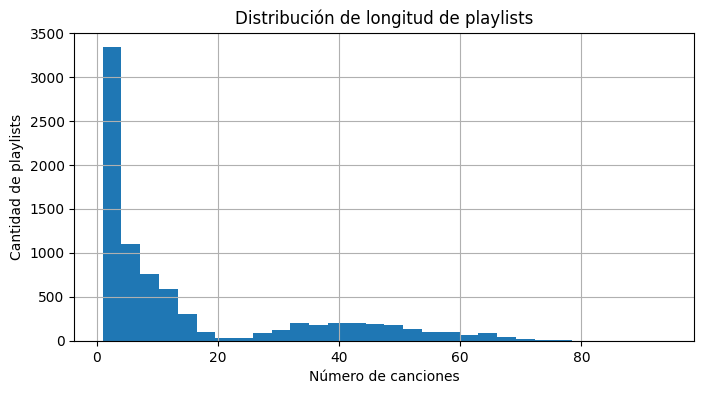

Media: 15.1484375 Máx: 94 Min: 1


In [17]:
# Distribución de longitud de playlists
import matplotlib.pyplot as plt
playlist_lengths = df_complete.groupby('pid').size()
plt.figure(figsize=(8,4))
playlist_lengths.hist(bins=30)
plt.title("Distribución de longitud de playlists")
plt.xlabel("Número de canciones")
plt.ylabel("Cantidad de playlists")
plt.show()
print("Media:", playlist_lengths.mean(), "Máx:", playlist_lengths.max(), "Min:", playlist_lengths.min())

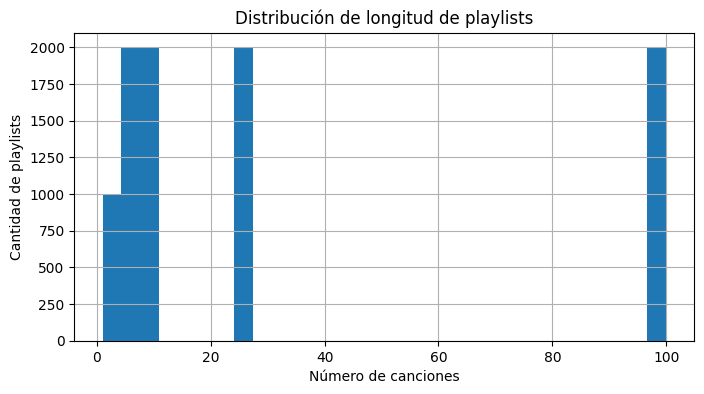

Media: 31.22222222222222 Máx: 100 Min: 1


In [18]:
# Distribución de longitud de playlists
import matplotlib.pyplot as plt
playlist_lengths = df_imputed.groupby('pid').size()
plt.figure(figsize=(8,4))
playlist_lengths.hist(bins=30)
plt.title("Distribución de longitud de playlists")
plt.xlabel("Número de canciones")
plt.ylabel("Cantidad de playlists")
plt.show()
print("Media:", playlist_lengths.mean(), "Máx:", playlist_lengths.max(), "Min:", playlist_lengths.min())

2.4. Análisis de géneros y moods


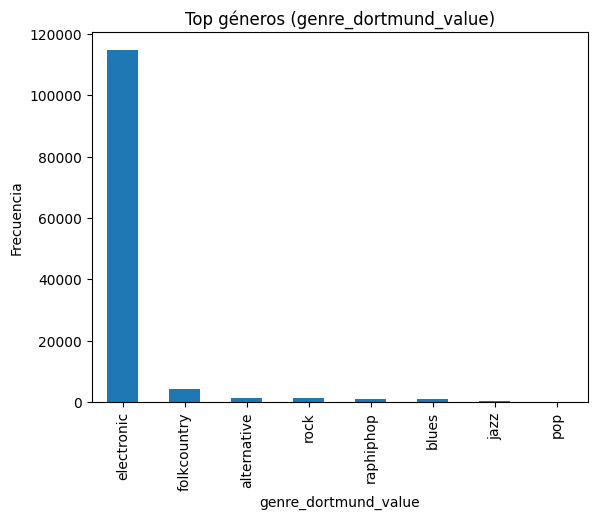

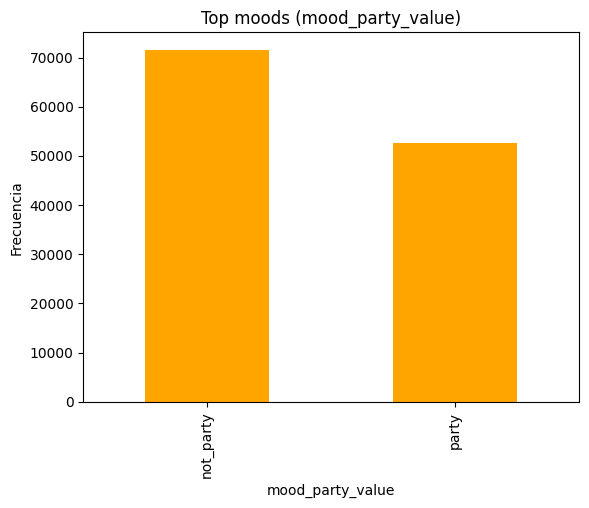

In [19]:
# Análisis de géneros y moods
top_genres = df_complete['genre_dortmund_value'].value_counts().head(10)
top_genres.plot(kind='bar')
plt.title("Top géneros (genre_dortmund_value)")
plt.ylabel("Frecuencia")
plt.show()

top_moods = df_complete['mood_party_value'].value_counts().head(10)
top_moods.plot(kind='bar', color='orange')
plt.title("Top moods (mood_party_value)")
plt.ylabel("Frecuencia")
plt.show()

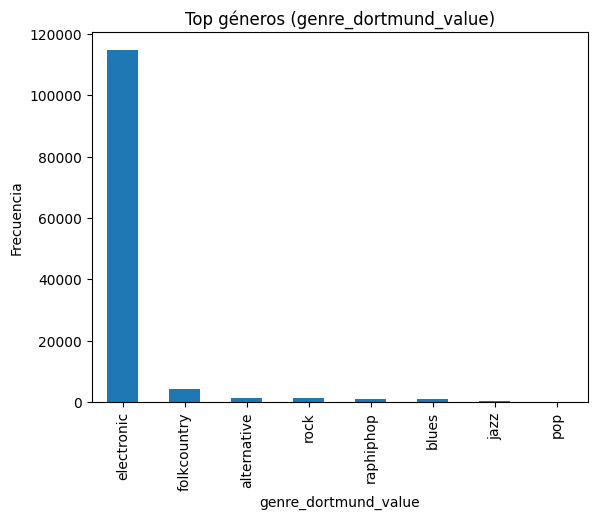

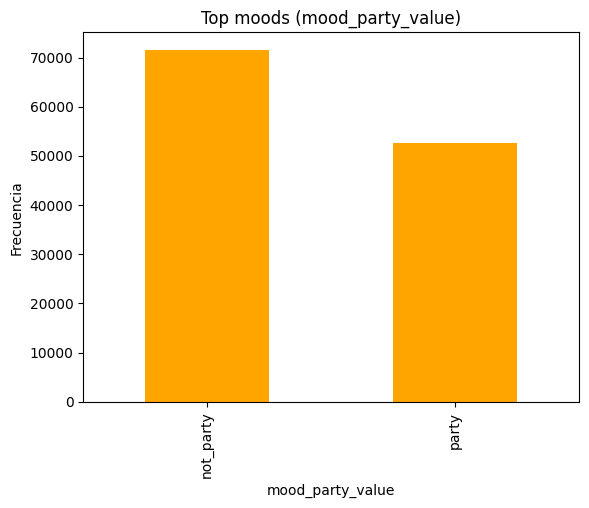

In [20]:
# Análisis de géneros y moods
top_genres = df_imputed['genre_dortmund_value'].value_counts().head(10)
top_genres.plot(kind='bar')
plt.title("Top géneros (genre_dortmund_value)")
plt.ylabel("Frecuencia")
plt.show()

top_moods = df_imputed['mood_party_value'].value_counts().head(10)
top_moods.plot(kind='bar', color='orange')
plt.title("Top moods (mood_party_value)")
plt.ylabel("Frecuencia")
plt.show()

2.5. Correlaciones numéricas


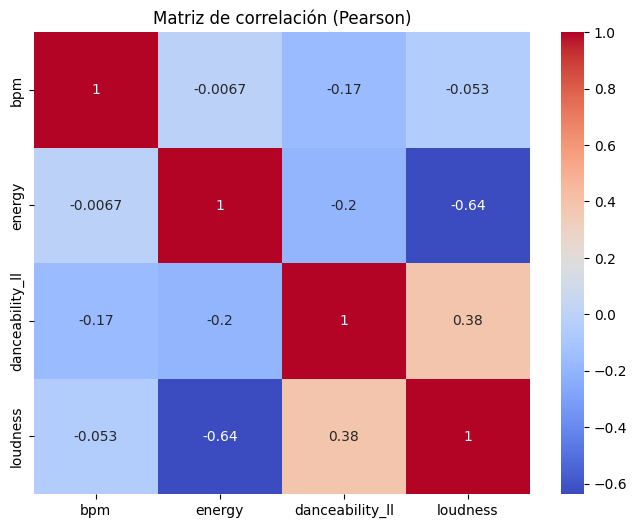

In [21]:
# Correlaciones numéricas
import seaborn as sns
num_cols = ['bpm', 'energy', 'danceability_ll', 'loudness']  # Ajusta según tus columnas
corr = df_complete[num_cols].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación (Pearson)")
plt.show()

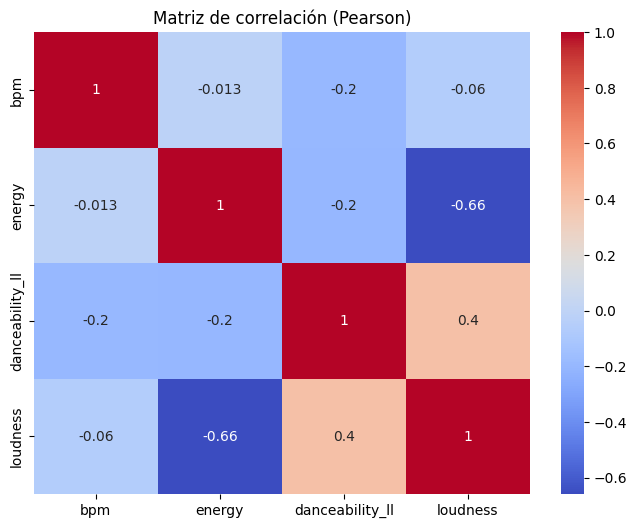

In [22]:
# Correlaciones numéricas
import seaborn as sns
num_cols = ['bpm', 'energy', 'danceability_ll', 'loudness']  # Ajusta según tus columnas
corr = df_imputed[num_cols].corr(method='pearson')
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación (Pearson)")
plt.show()

2.6. Outliers numéricos


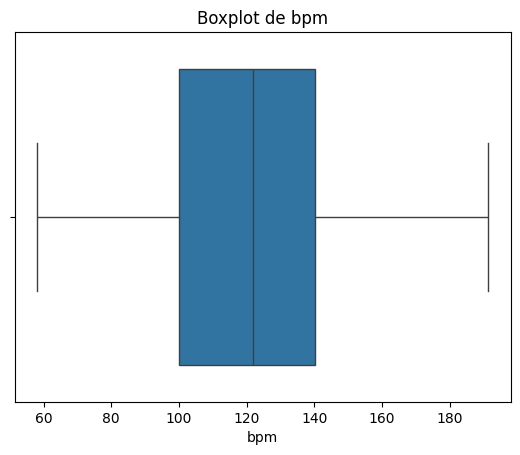

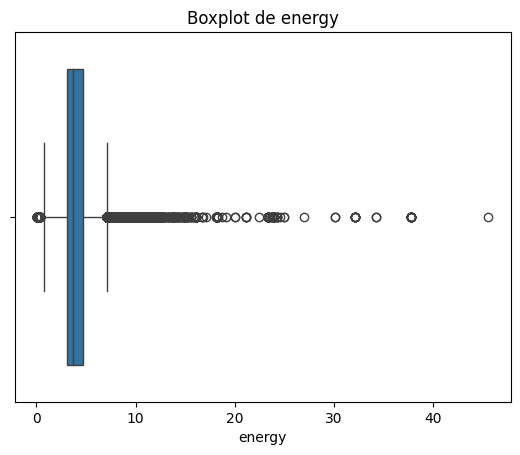

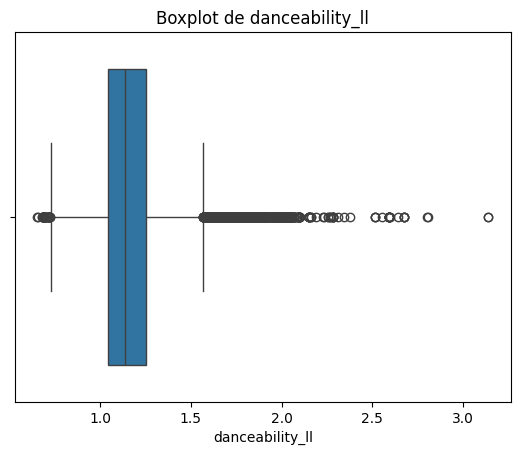

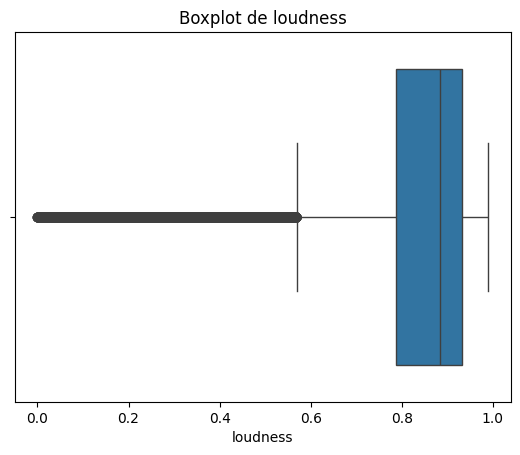

In [23]:
# Outliers numéricos con boxplots
for col in ['bpm', 'energy', 'danceability_ll', 'loudness']:
    plt.figure()
    sns.boxplot(x=df_complete[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

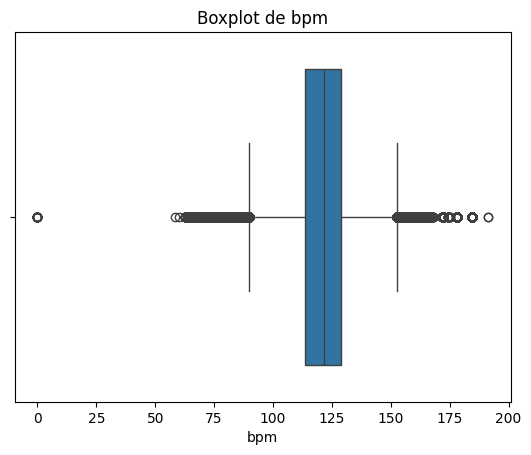

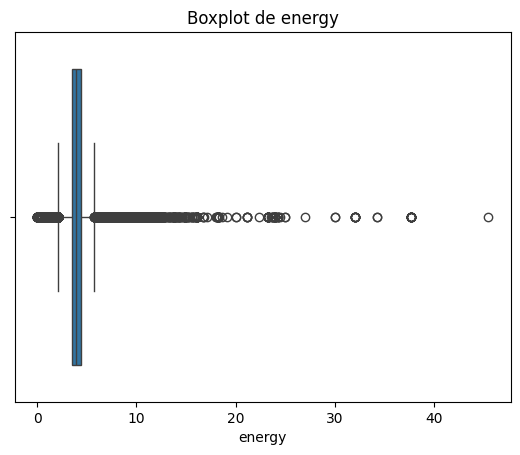

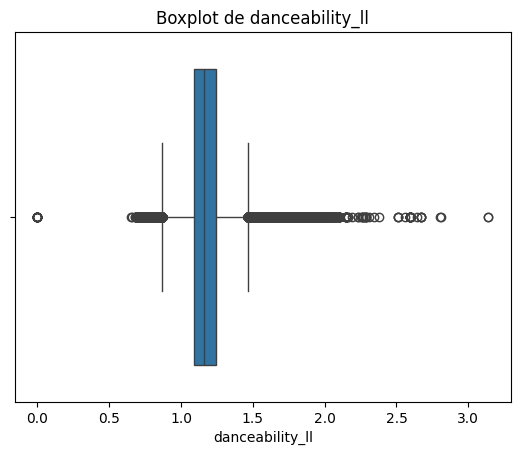

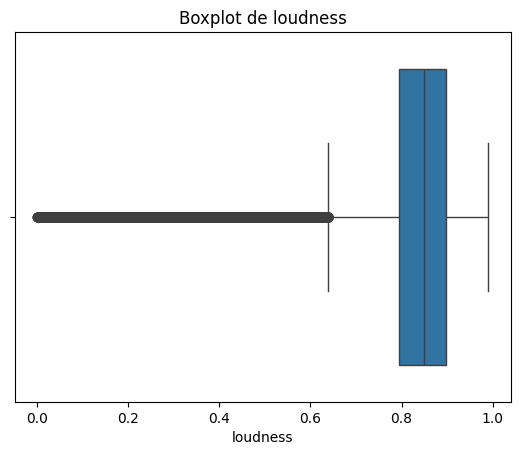

In [24]:
# Outliers numéricos con boxplots
for col in ['bpm', 'energy', 'danceability_ll', 'loudness']:
    plt.figure()
    sns.boxplot(x=df_imputed[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

2.7. Valores faltantes


name                        5.087996
pid                         0.000000
pos                         0.000000
artist_name                 0.000000
track_uri                   0.000000
                              ...   
timbre_prob                 0.000000
tonal_atonal_value          0.000000
tonal_atonal_prob           0.000000
voice_instrumental_value    0.000000
voice_instrumental_prob     0.000000
Length: 94, dtype: float64

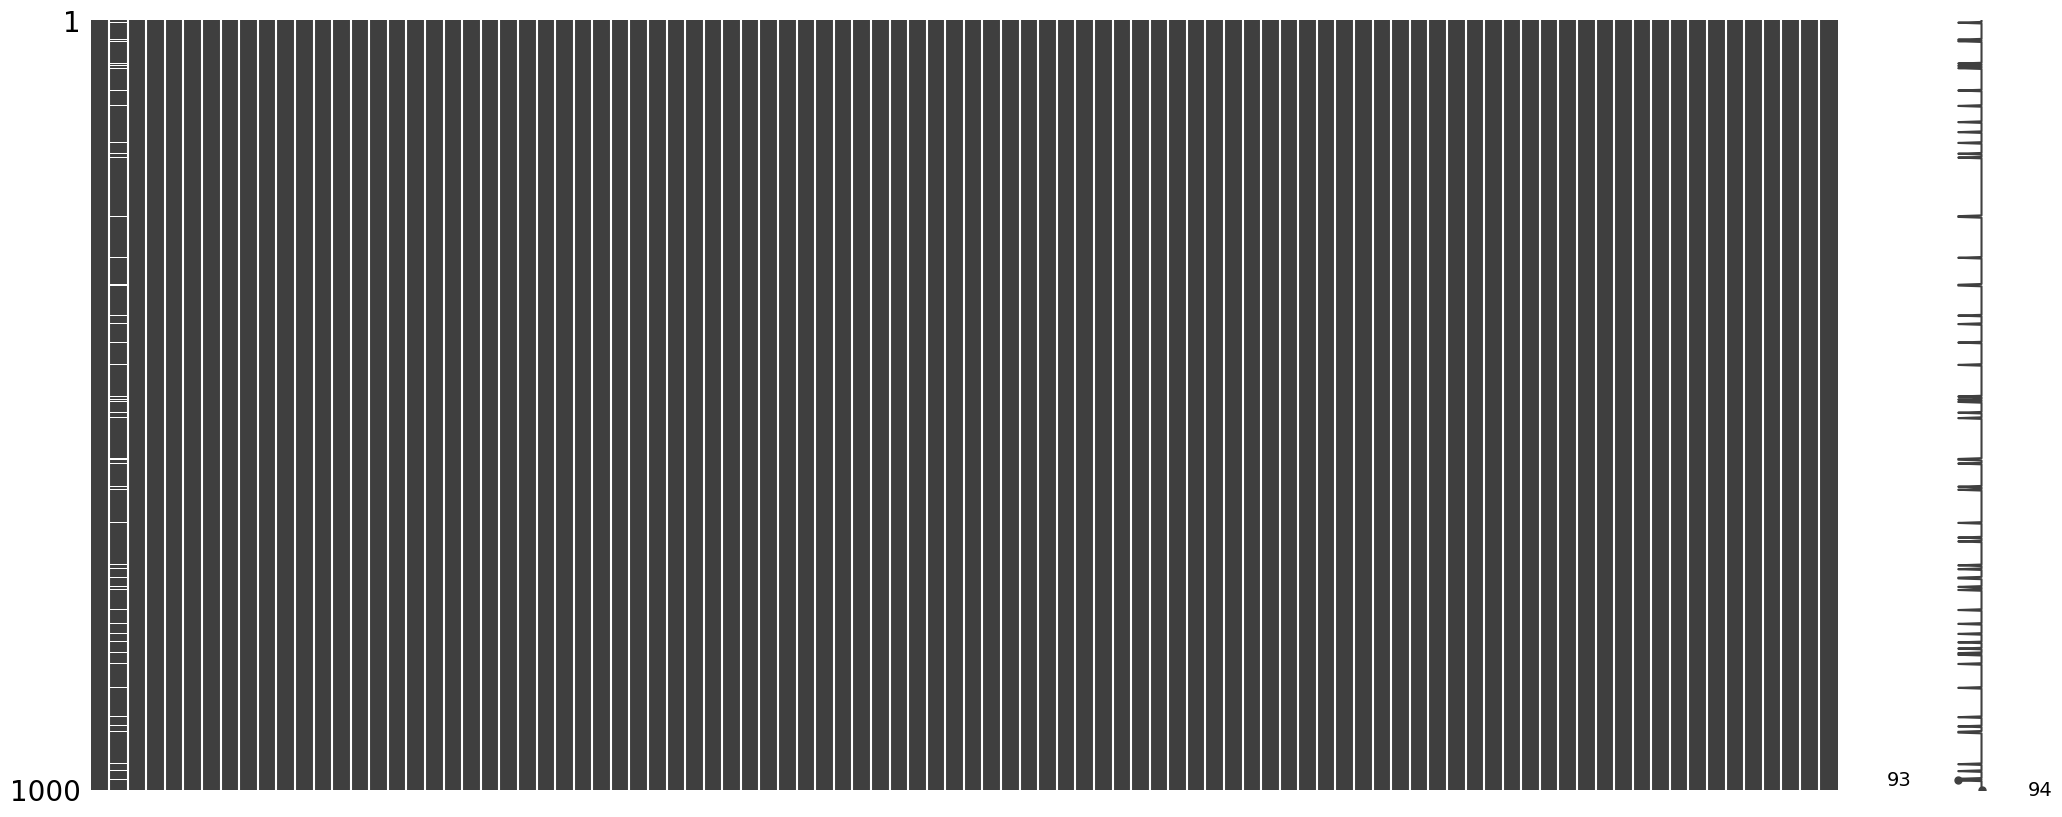

In [25]:
# Porcentaje de valores faltantes por columna
na_pct = df_complete.isna().mean() * 100
na_pct = na_pct.sort_values(ascending=False)
display(na_pct)

# Visualización rápida (opcional)
import missingno as msno
msno.matrix(df_complete.sample(1000, random_state=1))  # Muestra 1000 filas aleatorias
plt.show()

genre_dortmund_value       55.837722
gender_value               55.837722
danceability_value         55.837722
mood_sad_value             55.837722
moods_mirex_value          55.837722
                             ...    
moods_mirex_prob            0.000000
timbre_prob                 0.000000
tonal_atonal_prob           0.000000
voice_instrumental_prob     0.000000
was_imputed                 0.000000
Length: 95, dtype: float64

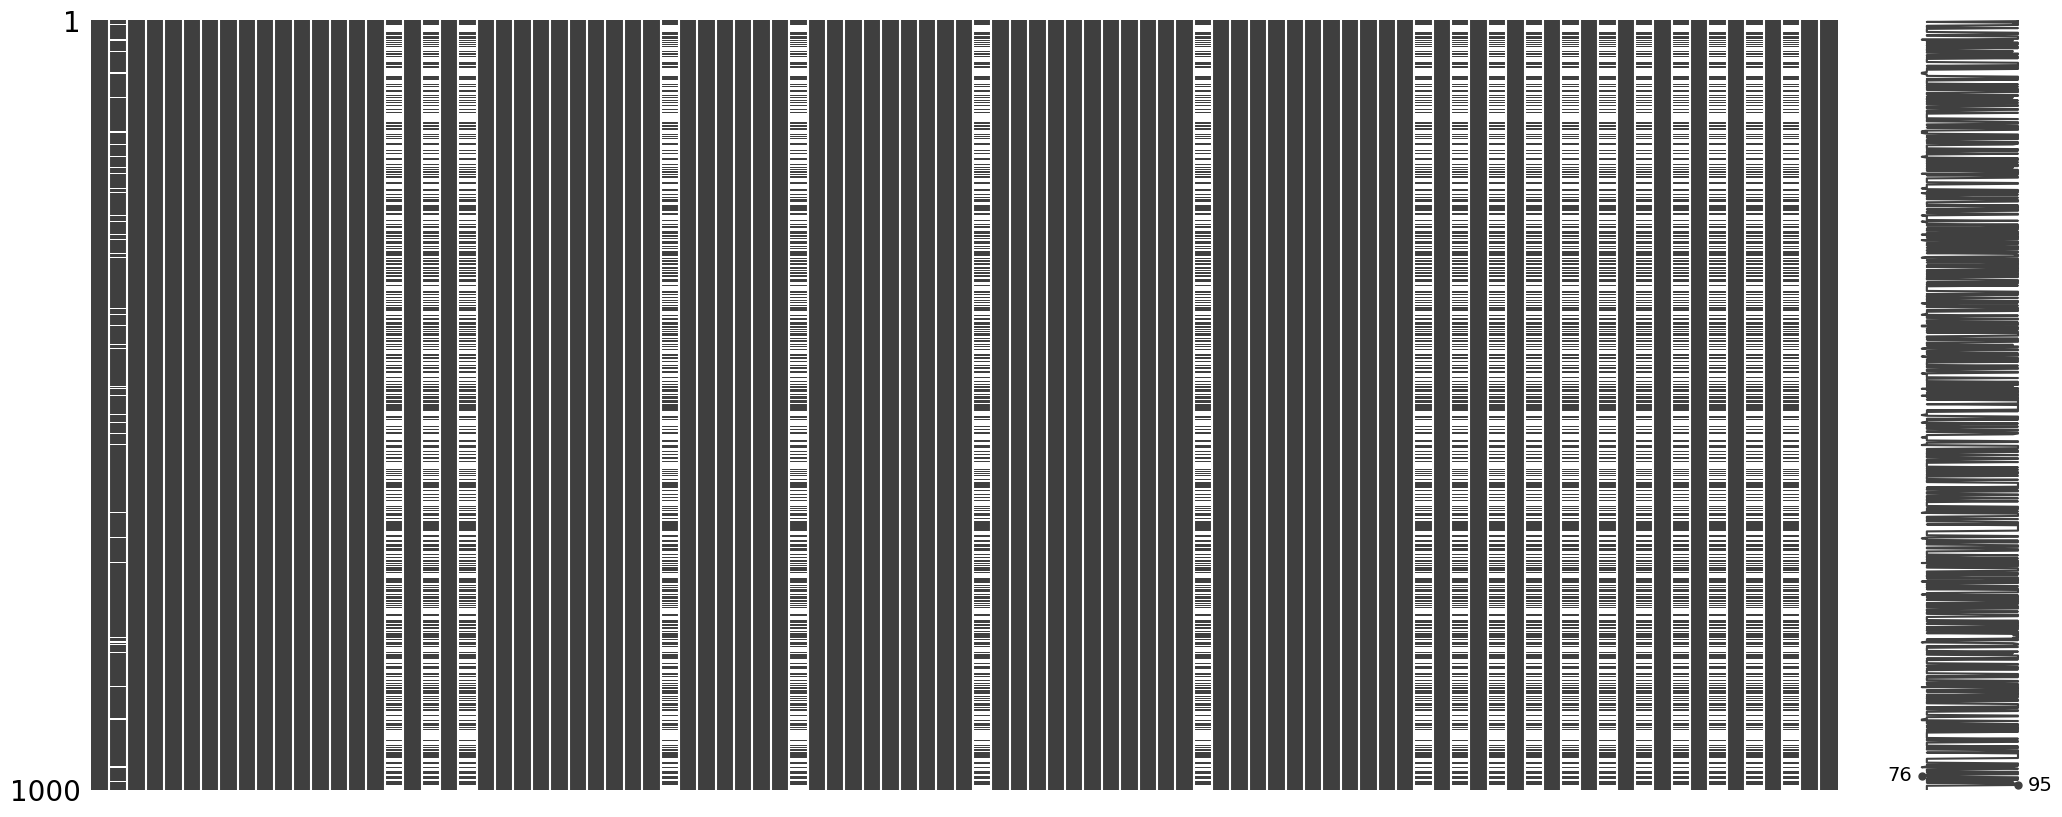

In [26]:
# Porcentaje de valores faltantes por columna
na_pct = df_imputed.isna().mean() * 100
na_pct = na_pct.sort_values(ascending=False)
display(na_pct)

# Visualización rápida (opcional)
import missingno as msno
msno.matrix(df_imputed.sample(1000, random_state=1))  # Muestra 1000 filas aleatorias
plt.show()

2.8. Canciones y artistas más frecuentes


In [27]:
# Canciones más repetidas
top_tracks = df_complete['track_name'].value_counts().head(10)
print("Canciones más repetidas:")
display(top_tracks)

# Artistas más frecuentes
top_artists = df_complete['artist_name'].value_counts().head(10)
print("Artistas más frecuentes:")
display(top_artists)

Canciones más repetidas:


track_name
Closer                   262
Caroline                 184
White Iverson            161
Ni**as In Paris          159
Trap Queen               156
Low Life                 151
Home                     142
Hotline Bling            141
I Don't Fuck With You    140
Chill Bill               139
Name: count, dtype: int64

Artistas más frecuentes:


artist_name
Drake                   2072
Luke Bryan              1357
Florida Georgia Line     845
Zac Brown Band           834
Kanye West               827
Kenny Chesney            808
Future                   778
Eminem                   729
JAY Z                    699
Tim McGraw               680
Name: count, dtype: int64

In [28]:
# Canciones más repetidas
top_tracks = df_imputed['track_name'].value_counts().head(10)
print("Canciones más repetidas:")
display(top_tracks)

# Artistas más frecuentes
top_artists = df_imputed['artist_name'].value_counts().head(10)
print("Artistas más frecuentes:")
display(top_artists)

Canciones más repetidas:


track_name
Closer                         335
Roses                          241
Ride                           229
Broccoli (feat. Lil Yachty)    226
Ignition - Remix               222
Gold Digger                    215
Forever                        213
No Role Modelz                 211
Let Me Love You                203
HUMBLE.                        202
Name: count, dtype: int64

Artistas más frecuentes:


artist_name
Drake             4877
Kanye West        2592
Kendrick Lamar    1902
Rihanna           1734
The Weeknd        1644
Eminem            1494
Luke Bryan        1486
J. Cole           1472
Chris Brown       1418
Future            1308
Name: count, dtype: int64

2.9. Diversidad de géneros/artistas por playlist


In [29]:
# Diversidad de géneros/artistas por playlist
diversity = df_complete.groupby('pid').agg({
    'genre_dortmund_value': pd.Series.nunique,
    'artist_name': pd.Series.nunique
}).rename(columns={'genre_dortmund_value': 'n_genres', 'artist_name': 'n_artists'})
display(diversity.describe())

,n_genres,n_artists
count,8192.000000,8192.000000
mean,1.651733,10.288086
std,0.981417,11.608034
min,1.000000,1.000000
25%,1.000000,2.000000
50%,1.000000,5.000000
75%,2.000000,13.000000
max,6.000000,78.000000


In [30]:
# Diversidad de géneros/artistas por playlist
diversity = df_imputed.groupby('pid').agg({
    'genre_dortmund_value': pd.Series.nunique,
    'artist_name': pd.Series.nunique
}).rename(columns={'genre_dortmund_value': 'n_genres', 'artist_name': 'n_artists'})
display(diversity.describe())

,n_genres,n_artists
count,9000.000000,9000.000000
mean,1.503444,18.972222
std,1.048650,22.524625
min,0.000000,1.000000
25%,1.000000,4.000000
50%,1.000000,9.000000
75%,2.000000,23.000000
max,6.000000,100.000000


2.10. Pairplot de variables numéricas


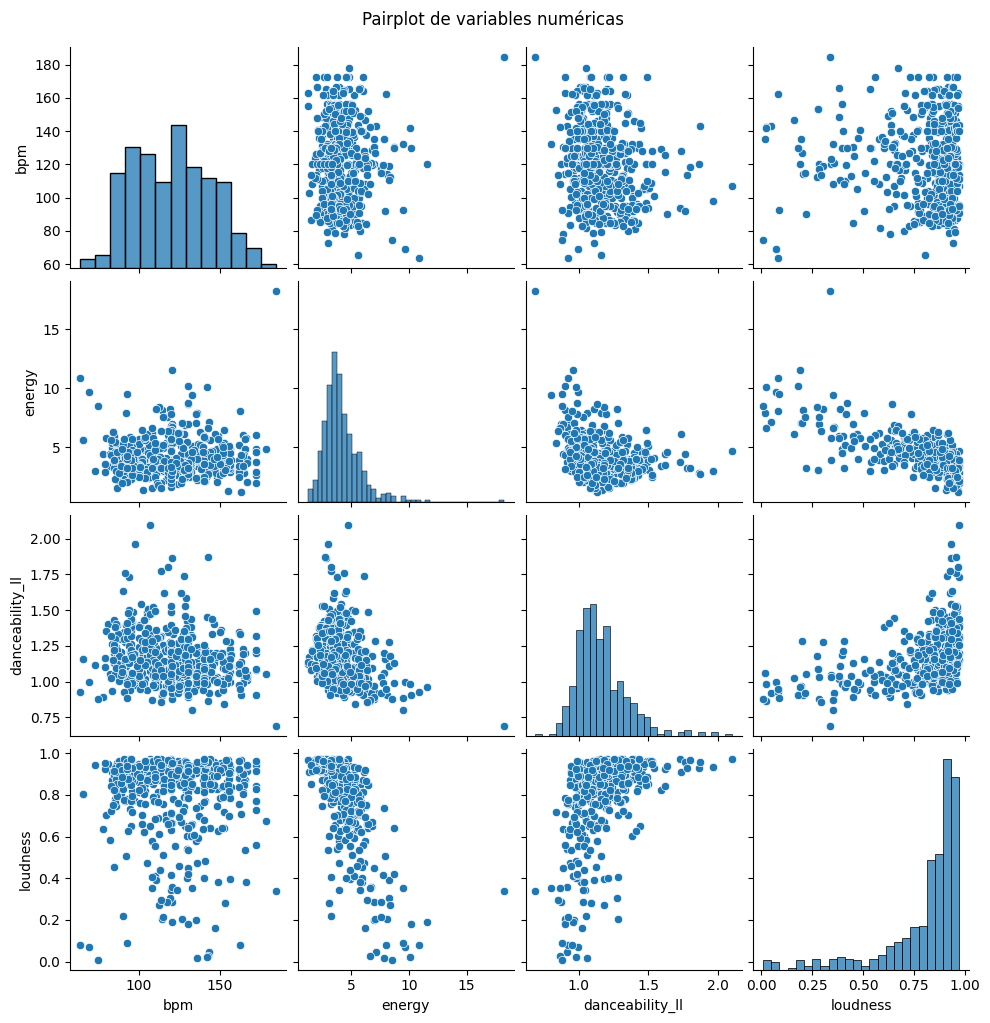

In [31]:
# Pairplot de variables numéricas
sns.pairplot(df_complete[num_cols].dropna().sample(500, random_state=1))  # Muestra 500 filas
plt.suptitle("Pairplot de variables numéricas", y=1.02)
plt.show()

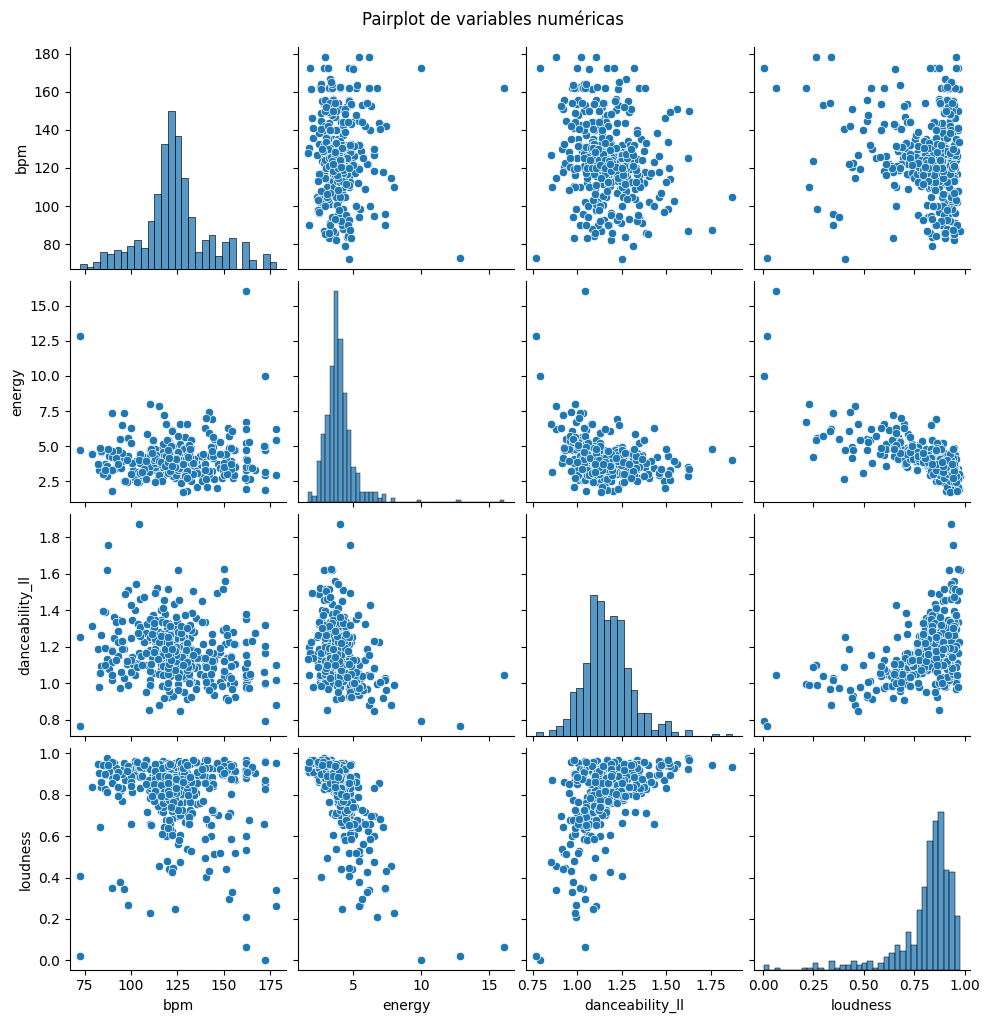

In [32]:
# Pairplot de variables numéricas
sns.pairplot(df_imputed[num_cols].dropna().sample(500, random_state=1))  # Muestra 500 filas
plt.suptitle("Pairplot de variables numéricas", y=1.02)
plt.show()